In [1]:
# Import
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

## FUNCTIONS IN ROTMOD:
- fcopy : I think this takes user input
- sortradii : sorts radii in ascending order
- getfactor : conversion from arcsec to kpc using distance as an input
- getrandd : takes the radial density profile from user and converts it to the right units
- getfile : get the name of the file where we want to store results

__Disk:__
- func : Casertano's equations: Eq 5 and elliptical functions 
- denzed : deciding which density function to use
- intzed : integrating the density function but not sure which step this is in Casertano's paper
- interpd : Lagrange interpolation (second order)
- interg : integration and returns velocity squared
- rotdisk : combines all functions in order:
     1. get density law 
     2. we need to know what kind of density distribution the user wants to supply. Choices are: 
          * TRUNCATED-EXPONENTIAL-DISK             USER=N
          * USER-SUPPLIED R and S(R) pairs         USER=Y
     3. get the surface densities from the user
     4. calculate the surface densities: this is where they use the piecewise function from Casertano's paper Eq 3. 
     5. try to fit an exponential and fit H and DENS0
     6. determine the disk mass and allow the user to modify it
     7. get radii for which we should calculate the rotation curve
     8. calculation
            
__BULGE:__
- interpb : 
- mu : 
- one : 
- two : 
- sign : 
- tintd : 
- rotbulge : combines all functions in order:
     1. determine the bulge mass and allow the user to modify it
     2. get radii for which we should calculate the rotation curve
     3. calculation

# ROTDISK

In [2]:
# USER= 
# UNITS=KPC,MAG/ARCSEC**2 
# TYPE= 
# ZLAW=SECH-SQUARE 
# RADII=1:13:0.01 
# Z0=.93 
# RADDENS=<NGC5005-disk_kpc 
# FILE=disk_from-mag.dat 
# DISTANCE=16.5 
# MASS=1

## User input: 
- __Density law:__<br>
     Case 1: flat disk: z0=0<br>
     Case 2: the Van der Kruit and Searle law (SECH-SQUARED): D(Z)=sech(Z/Z0)^2/Z0<br>
     Case 3: an exponential density law (EXPONENTIAL): D(Z)=exp(-Z/Z0)/Z0 <br>
     Case 4: a simple sech law (SIMPLE-SECH): D(Z)=2*sech(Z/Z0)/Z0/PI <br><br>
- __User supplies density distribution:__<br>
     NO: USER=N, Truncated-exponential disk<br>
     YES: USER=Y, radius and density pairs provided<br><br>
- __Units:__<br>
     'KPC,MSUN/PC\*\*2'<br>
     'ARCSEC,MAG/ARCSEC\*\*2'

In [3]:
# User input
user = True             # user = False means NO (let program calculate density) 
                        # user = True means YES (radius-density provided)
units = 'KPC,MSUN/PC**2'
zlaw = 2                # Case 2: sech-squared density law
z0 = 0.93
distance = 16.5         # Distance in MPC
h = 10.0                # GUESS: radial scale-length (KPC)
dens0 = 10**2.4         # GUESS: central surface density (MSUN/KPC^2)

mode = zlaw             # ??? is this an uncessary variable? see below:
                        # It is but I wanted to make sure that we can use this python notebook for future work so this makes sure we can change the density law in the future
raddens = "../data/gasmsd_kpc_linear.txt"         # Gas density with 2 columns, units: KPC, MSUN/PC^2
file = 'output.txt'     # Output file

#rawtotaldata = np.loadtxt("../NGC_5005/traced_data/ngc5005_data.txt")  # "raw" total rotation curve data points
#rawr,rawv,rawe1,rawe2 = rawtotaldata.T            # extracting the array of radius points, rawr, to fit component to

## Parameters

In [4]:
# Parameters 
G = 0.00000431158              # gravitational constant (KPC/MSUN*(KM/S)^2)  
CONSTANT = 2.0 * np.pi * G / 3.0
EPS = 0.000001
naccur = 1                     # GUESS -> accuracy of calculations, range between 1-10, 
                               # The programme needs more time for higher accuracies. 
                               # If no ZLAW is specified, the accuracy parameter is always 10

## Are data pairs (radius vs density) provided or not?

If user is __True__, the radius and density data is provided. It then calculates $h$ and $dens0$.<br>
If user is __False__, user has to provide $h$ and $dens0$, then it calculates the radius and density pairs.

### Check units

The accepted units are radius in KPC and density in MSUN/PC^2. <br>
If this isn't the case, the units need to be converted.<br>
The conversion goes as follows: <br>
- from ARCSEC to KPC: RADIUS in KPC = 4.8481E-3 $\times$ DISTANCE $\times$ RADIUS in ARCSEC
- from MAGnitudes to MSUN: M = $10^{- 0.4 \space \times \space \rm MAG}$<br>
- from $ \rm PC^{-2}$ to $\rm KPC^{-2}$: DENSITY $\times$ 1.0E6

In [5]:
# This checks if the user has provided density ditribution data (i.e. radius-density pairs or not)
if user == True:            # Choose user==True for density data, == False otherwise 
    
    if units == 'KPC,MSUN/PC**2':
        mudata = np.loadtxt(raddens)
        if np.shape(np.loadtxt(raddens))[1] == 2:     # this just checks if the file has 2 or 4 columns
            xdinp, ydinp = mudata.T
        if np.shape(np.loadtxt(raddens))[1] == 4:
            xdinp, ydinp, xerror, yerror = mudata.T
      
    if units == 'ARCSEC,MAG/ARCSEC**2':
        mudata = np.loadtxt(raddens)
        if np.shape(np.loadtxt(raddens))[1] == 2:
            xdinp, ydinp = mudata.T
        if np.shape(np.loadtxt(raddens))[1] == 4:
            xdinp, ydinp, xerror, yerror = mudata.T
                
        # Conversion
        # ARCSEC to KPC
        xdinp = 4.8481E-3 * distance * xdinp

        # MAG/ARCSEC^2 to MSUN/PC^2
        ydinp = 10**(-0.4 * ydinp)
        ydinp = (4.8481E-3 * distance)**(-2) * ydinp
        
    LEN1 = len(xdinp)                   # GUESS: defined as length of radius array
    LEN2 = len(ydinp)                   # GUESS: defined as lenght of density array
    #ndinp = LEN2-1                      # number of surface densities????
    ndinp = LEN2                        # number of surface densities. GUESS: length of density array again
    rcut = xdinp[ndinp-1]               # takes second to last radius value
    delta = rcut - xdinp[ndinp-2]       # difference between the second to last radius value and the third to last radius value
        
    print("Rcut = {:.4} kpc".format(rcut))
    print("Delta = {:.4} kpc".format(delta))
    
    # Now try to fit an exponential and fit H and DENS0
    s = 0.0
    sx = 0.0
    sy = 0.0
    sxy = 0.0
    sxx = 0.0
    n = 0
    while n < ndinp:
        if ydinp[n] > 0.0:
            s += 1.0
            sx += xdinp[n]
            sxx += xdinp[n] * xdinp[n]
            sy += np.log(ydinp[n])
            sxy += xdinp[n] * np.log(ydinp[n])
        n += 1
    det = s * sxx - sx * sx;
    h = det / ( sx * sy - s * sxy )
    if ( h > ( 0.5 * rcut ) ):
        h = 0.5 * rcut
    if ( h < ( 0.1 * rcut ) ):
        h = 0.1 * rcut;
    dens0 = np.exp( ( sy * sxx - sx * sxy ) / det )
        
    print("dens0 = {:.4} Msun/PC^2".format(dens0))
    print("h = {:.4} kpc".format(h))

Rcut = 11.18 kpc
Delta = 0.0259 kpc
dens0 = 170.7 Msun/PC^2
h = 1.94 kpc


If user is false, it uses Casertano's piecewise function to calculate the radius-density pairs

In [6]:
if user == False:           # If USER=N, calculate density

    # User need to provide dens0 (in MSUN/PC^2) and h (in KPC)
    dens0 = dens0           # central density of exponential DISK in MAG/ARCSEC^2
    # convert disk central surface brightness from MAG/ARCSEC^2 to MSUN/KPC^2
    dens0 = 10**(-0.4 * dens0)       
    dens0 = (4.8481E-3 * distance)**(-2) * dens0
    dens0 = dens0 * 1.0e6        
    print("dens0 = {:.4}".format(dens0))

    h = h                   # radial scale length
    z0 = 0.2*h              # scale height of DISK in kpc [0.0]. 
                              # note: The integration in Z is the most time consuming part
                              # of the calculation. For example it takes about 0.2 seconds
                              # to calculate a point on the rotation curve for a disk with zero
                              # thickness, and about 2 seconds for a disk with non-zero thickness.
    rcut = 4*h              # cutoff radius
    delta = 0.2*h           # softening parameter of DISK in kpc [0.0]. It may be wise
                              # to have a non-zero softening in case of a truncated disk, 
                              # because then the sharp features in the calculated rotation 
                              # curve will be smoothed out. A softening parameter of about 
                              # 0.2 scale lengths would be sufficient.

    # Now calculate the surface densities
    LEN1 = 20016              # don't need to pre-define array size in python  
    LEN2 = 40001              # LEN1 and LEN2 is defined after the file is called
    xdinp = np.zeros(LEN2)    # radii surface density
    ydinp = np.zeros(LEN2)    # surface densities
    rdinp = rcut + delta      # max radius, where galaxy ends
    ndinp = LEN2 - 1          # number of surface densities
    xstep = rdinp / (ndinp - 1)        # step in radius

    i = 0                              # counter 
    while i < ndinp:
        # Casertano's piecewise function
        xdinp[i] = x = xstep * i
        if x >= rcut and delta > 0.0:
            y = dens0 * np.exp(-rcut / h) * (rcut + delta - x) / delta
        if x >= rdinp:
            y = 0.0                    # end of disk
        else:
            y = dens0 * np.exp(-x / h) # exponential disk
        ydinp[i] = y
        i += 1
    print(len(xdinp))
    print(xdinp[1])
    print(len(ydinp))

## Determining disk or gass total mass

GIPSY output of _rmass_ is $4.183 \space \times \space 10^9$ solar masses (MSun) <br>

In [7]:
# Now we determine the disk mass and allow the user to modify it.
dkmass = 0.0
n = 1
print(ndinp)
print(len(xdinp))

xdinp_pc = xdinp*1e3            # converts all radii from KPC to PC: 1 KPC = 10^3 PC

while n < ndinp:
    x = xdinp_pc[n] 
    if n < ndinp - 1:
        step = ( xdinp_pc[n+1] - xdinp_pc[n-1] ) / 2.0    # subtracts the next radius value from the previous radius value and divides by two
    else:
        step = xdinp_pc[n] - xdinp_pc[n-1]                # subtracts the previous radius value from the current value
    dkmass += ydinp[n] * step * x                         # multiplies the density value with the difference of radii and the current radii 
    n += 1

dkmass *= ( 2.0 * np.pi )
rmass = dkmass / 1.0e9
print("Disk Mass in 10^9 MSUN {:.4}.".format(rmass))
print(dkmass)
print("dens0 = {:.4f}.".format(dens0))

146
146
Disk Mass in 10^9 MSUN 3.851.
3851251066.3644156
dens0 = 170.7400.


In [8]:
# this is where you would put in your own mass value**
# i.e rmass=91.6
rmass_new = 4.183                  # changed the name of the variable because it was messing up the calculation

# checks if the input is a valid value
if ( rmass_new <= 0.0 ):
    print("error in disk mass")
        
rmass_new = ( rmass_new * 1.0E9 ) / dkmass
dkmass_new = rmass_new * dkmass;
    
n = 0
while n < ndinp:
    ydinp[n] *= rmass_new
    n += 1
dens0 = dens0 * rmass_new
print("new dens0 = {:.4f}.".format(dens0))
print("new dkmass = {:.4e}.".format(dkmass_new))
print("new rmass is now a ratio = {:.4e}.".format(rmass_new))

new dens0 = 185.4477.
new dkmass = 4.1830e+09.
new rmass is now a ratio = 1.0861e+00.


In [9]:
# calculates z1, not sure why they do this in this part of the calculation
z1 = z0
if ( z1 < ( 0.1 * h ) ):
    z1 = 0.1 * h
if ( z1 > ( 0.3 * h ) ):
    z1 = 0.3 * h

print("z1 = {:.4f}.".format(z1))
print("delta = {:.4f}.".format(delta))

z1 = 0.5820.
delta = 0.0259.


## Calculating radii

In [10]:
# Now get radii for which we should calculate the rotation curve.
#radii = rawr                    # the same points as the raw rc data points
#radii = np.zeros()              # radii and radius is the same
radius = np.zeros(len(xdinp))
rings = radius
nring = len(radius)              # number of sampling radii
ntimes = len(xdinp)             # number of items
   
while n < nring:
    if rings[n] < 0.0:
        print("error in rings")
    n += 1
    
#nitems = 1
#input_level = 2

# find width
if z1 < delta:
    width = z1
else:
    width = delta
print("width = {:.4f}.".format(width))

width = 0.0259.


In [11]:
# If user provided radius-density pairs
if ( user == True ):
    r1 = 0.0
    r2 = 0.0

    radius[0] = 0.0
    l = m = n = 0
    while l < nring or n < ndinp and m < ( LEN1 + LEN2 + 1 ) and l < nring and radius[m] >= r1 and n < ndinp and radius[m] >= r2:
            r1 = rings[l]
            l += 1
            r2 = xdinp[n]
            n += 1
            if ( r1 > radius[m] and r2 > radius[m] ):
                if r1 < r2:
                    radius[m] = r1
                    m += 1
                else:
                    radius[m] = r2
                    m += 1
            elif ( r1 > radius[m] ):
                radius[m] = r1
                m += 1
            elif ( r2 > radius[m] ):
                radius[m] = r2
                m += 1
    nradii = m + 1
print(radius)

[ 0.0172  0.2421  0.3328  0.4581  0.5229  0.6136  0.6654  0.7302  0.7776
  0.8122  0.8857  0.9332  0.972   1.0066  1.0412  1.0887  1.1923  1.2529
  1.309   1.4214  1.4819  1.5295  1.6505  1.737   1.8192  1.9057  2.0096
  2.1047  2.1869  2.2908  2.412   2.5244  2.6023  2.6758  2.797   2.9916
  3.0694  3.1299  3.2251  3.2812  3.3418  3.4239  3.5017  3.5665  3.6271
  3.6876  3.7524  3.8086  3.8648  3.921   3.9902  4.068   4.1285  4.2021
  4.3404  4.4226  4.5005  4.5869  4.6778  4.7902  4.8854  4.9805  5.0584
  5.1362  5.2227  5.3049  5.3871  5.4736  5.5644  5.638   5.7202  5.798
  5.8889  5.9754  6.0532  6.1441  6.2262  6.3128  6.4079  6.5118  6.6156
  6.7021  6.7886  6.8708  6.966   7.0525  7.1693  7.325   7.4159  7.511
  7.6105  7.7014  7.7706  7.87    8.0042  8.1166  8.2118  8.281   8.3675
  8.4497  8.5318  8.6183  8.6832  8.8     8.8951  8.9686  9.0465  9.133
  9.2107  9.293   9.3708  9.44    9.5308  9.6216  9.6951  9.7599  9.8161
  9.881   9.9545 10.0193 10.0885 10.1404 10.1966 10.25

In [12]:
# If there were no radius-density pairs provided
if ( user == False ):
    if width != 0.0 :
        
        s1 = rcut - width
        s2 = rcut + 2.0 * width
        indmin = indmax = nring - 1
        n = 0
        while n < nring:
            if ( rings[n] > s1 ): 
                if indmin < n:
                    indmin = indmin
                else: 
                    indmin = n
            if ( rings[n] > s2 ):
                if indmax < n:
                    indmax = indmax
                else: 
                    indmax = n
            n += 1
        
        m = n = 0
        while n < nring:
            if ( n < indmin or n > indmax ):
                radius[m] = rings[n]
            if ( n == indmin ):
                stp = width / 5.0
                l = 0
                while l < 15:
                    radius[m] = rcut - width * l * stp
                    l += 1
            else:
                radius[m] = rings[n]
                
            n += 1
            m += 1

# What is this doing? the if statements above are if user is True or False but what is "else"? If user is either?
else:
    nradii = 0
    n = 0
    while n < nring:
        radius[nradii] = rings[n] 
        nradii += 1
        n += 1

## Plotting the radius - density pair

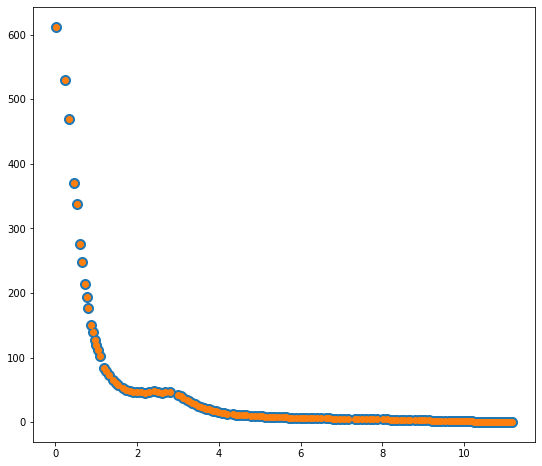

In [13]:
# Plot 
plt.figure(figsize=(9,8))
plt.scatter(xdinp,ydinp, s=100)
plt.scatter(radius,ydinp)
plt.show()

## Functions

In [14]:
# Casertano's equations: Eq 5 and elliptical functions 
def func(x,y,z):
    if( x==y ) & ( z == 0):
        r = 0
    elif( x==0 ) | ( y == 0):
        r = 0
    else:
        xxx = (x*x + y*y + z*z) / (2.0 * x * y)
        rrr = (xxx*xxx - 1.0)
        ppp = 1.0 / (xxx + np.sqrt(rrr))
        fm = 1.0 - ppp*ppp
        el1 = (1.3862944 + fm * (0.1119723 + fm * 0.0725296)) - (0.5 + fm * (0.1213478 + fm * 0.0288729)) * np.log(fm)
        el2 = (1.0 + fm * ( 0.4630151 + fm * 0.1077812 ) ) - (fm * (0.2452727 + fm * 0.0412496)) * np.log(fm)
        r = ((1.0 - xxx * y/x) * el2 / (rrr) + (y/x - ppp) * el1 / np.sqrt(rrr)) / np.pi
        r *= np.sqrt(x / (y * ppp))
    return r

In [15]:
# DISK Density distribution 
# There are three distribution laws possible; 
# the Van der Kruit and Searle law (SECH-SQUARED): D(Z)=sech(Z/Z0)**2/Z0,
# an exponential density law (EXPONENTIAL): D(Z)=exp(-Z/Z0)/Z0 
# a simple sech law (SIMPLE-SECH): D(Z)=2*sech(Z/Z0)/Z0/PI. 

# case 1 is a flat disk, z0 = 0
#####################################


# Sech-squared law:
def denzed_case2(z,z0): 
    r = np.cosh(z / z0)
    r = r * r * z0
    r = 1.0 / r
    return r

# Exponential:
def denzed_case3(z,z0):
    r = np.exp(-z / z0) /z0
    return r

# Simple-sech
def denzed_case4(z,z0):
    r = 2 / z0 / np.pi / np.cosh(z/z0)
    return r

def denzed(z,z0,mode):
    #mode = input("Which Z density law? 2 or 3 or 4: ")
    #The above results in the user being asked for every point entered; this was likely used as a backend.
    if mode == 2:
        return denzed_case2(z,z0)
    if mode == 3:
        return denzed_case2(z,z0)
    if mode == 4:
        return denzed_case4(z,z0)
    else:
        return np.nan
        print("Error occured in denzed; no mode selected. Returned nan.")

In [16]:
"""intzed computes the integral over Z that defines the kernel of the integral formula for the rotation velocity. 
This is done for an arbitrary vertical density profile, specified in the function denzed.
The interval of integration is divided into several subintervals, in each of which Simpson's rule is used. 
It is thus possible to have different steps in different regions of the interval of integration, 
and to compute the integral more accurately. An attempt has been made at optimizing the subdivision. 
It is still possible that the kernel is not accurate, especially when R is very close to U. 
It is NOT recommended that the programme is used with very small, but non-zero, values of the thickness. 
On the other hand, the situation with an infinitely thin disk is dealt with properly, the density profile in 
Z being then treated as a Dirac delta function."""

def intzed(r,u,z0,naccur,mode):
    zeds = np.array([0.02, 0.50, 1.00, 3.00, 10.00])
    
    if (z0 != 0.0) & (naccur != 0):
        n = 10
        n = naccur * n
        
        if (np.abs(r - u) <= (0.2 * z0)) & (naccur > 1):
            n = 200
        
        zne = 0.0
        res = 0.0
        i = 0
        while i < 5: 
            zol = zne
            zne = zeds[i] * z0
            step = (zne - zol) / n
            z = zol
            res += step * func(r,u,z) * denzed(z,z0,mode) / 3.0
            w = 4.0 / 3.0         
            j = 0.0
            while j < n:
                z += step
                res += step * func(r,u,z) * denzed(z,z0,mode) * w
                w = 2.0 - w
                j += 1
            res -= step * func(r,u,z) * denzed(z,z0,mode) / 3.0
            i += 1
    else:
        res = func(r,u,z0)
    return res

In [71]:
# interp does a Lagrange interpolation (second order)
def interpd(x1,y1,n1,x2,y2,n2):  
    i = 0

    while i < n2:
        x = x2[i]
        y = 0.0
        j = 1
        done = 0
        while (done != 1) and (j < (n1 - 1)):
            if ((x1[j-1] <= x ) and (x1[j+1] >= x)):
                k = j - 1
                while (k <= j + 1):
                    f = 1.0
                    l = j - 1
                    while l <= j + 1:
                        if (l != k):
                            f *= (x - x1[l]) / (x1[k] - x1[l]) #So we are getting negative f when x1[l] > x or x1[k] < x1[l], but not both
                        l += 1        
                    y += f * y1[k]
                    k += 1
                done = 1
            j += 1
        if (y > 0.0):
            y2[i] = y
        else: 
            y2[i] = 0.0
        i += 1
    return x2,y2

In [72]:
# interg does the integration
def interg(xd,yd,nd,r,rstart,z0,step,ndens,naccur,mode):
    vsq = 0.0
    i = 1
    k = 0
    while k < ndens:
        if (k == 0 or k == (ndens - 1)):
            iw = 1
        else:
            iw = 4 - 2 * ((k + 1) % 2)
        
        x = rstart + step * k
        y = 0.0

        if (x < xd[nd-1]): 
            done = False
            while (done == False) & (i < (nd - 1)):
                #if i==1:
                    #print("            Checking xd...") #This if (xd...) loop is entered many times in quick succession; doesn't seem to be hanging so much as running too much. Not seeing the "increased i for the first time" as frequently as I would have expected, but this if statement IS completing quickly.
                if (xd[i-1] <= x) & (xd[i+1] >= x):
                    k1 = i - 1
                    while k1 <= (i + 1):
                        f = 1.0
                        k2 = i - 1
                        while k2 <= (i + 1):
                            if (k1 != k2):
                                f *= (x - xd[k2]) / (xd[k1] - xd[k2])
                            k2 += 1
                        y += f * yd[k1]
                        done = True
                        k1 += 1
                else:
                    i += 1
            if (y > 0.0):
                res = intzed(r,x,z0,naccur,mode)
                vsq += CONSTANT * res * y * step * iw
        k += 1
    return vsq

In [73]:
print(radius)

[ 0.0172  0.2421  0.3328  0.4581  0.5229  0.6136  0.6654  0.7302  0.7776
  0.8122  0.8857  0.9332  0.972   1.0066  1.0412  1.0887  1.1923  1.2529
  1.309   1.4214  1.4819  1.5295  1.6505  1.737   1.8192  1.9057  2.0096
  2.1047  2.1869  2.2908  2.412   2.5244  2.6023  2.6758  2.797   2.9916
  3.0694  3.1299  3.2251  3.2812  3.3418  3.4239  3.5017  3.5665  3.6271
  3.6876  3.7524  3.8086  3.8648  3.921   3.9902  4.068   4.1285  4.2021
  4.3404  4.4226  4.5005  4.5869  4.6778  4.7902  4.8854  4.9805  5.0584
  5.1362  5.2227  5.3049  5.3871  5.4736  5.5644  5.638   5.7202  5.798
  5.8889  5.9754  6.0532  6.1441  6.2262  6.3128  6.4079  6.5118  6.6156
  6.7021  6.7886  6.8708  6.966   7.0525  7.1693  7.325   7.4159  7.511
  7.6105  7.7014  7.7706  7.87    8.0042  8.1166  8.2118  8.281   8.3675
  8.4497  8.5318  8.6183  8.6832  8.8     8.8951  8.9686  9.0465  9.133
  9.2107  9.293   9.3708  9.44    9.5308  9.6216  9.6951  9.7599  9.8161
  9.881   9.9545 10.0193 10.0885 10.1404 10.1966 10.25

In [74]:
# Calculation
print("Setting variables...")
i = 0
j = 0
velocs = np.zeros(len(radius))
nradii = len(radius)
#densit = np.zeros(LEN1+LEN2+1)
densit = np.zeros(len(radius))

#####################################
########### USER SETTINGS ###########

print("Variables set. Interpolating...")
#interpd( xdinp, ydinp, ndinp, radii, densit, nradii )
radius = interpd( xdinp, ydinp, ndinp, radius, densit, nradii )[0]
densit = interpd( xdinp, ydinp, ndinp, radius, densit, nradii )[1]

print("Interpolation complete. Calculation will now begin.")
while i < nradii:
    r = radius[i]
    vsq = 0.0

    if i==0:
        print("Loop variables set. Setting variable j...")
    
    while j < nring and rings[j] < r:
        j += 1

    if i==0:
        print("Initial value of j set to "+str(j)+". Setting additional variables...")
    
    skip = rings[j] != r
    #z1 = z0
    
    r1 = r - 3.0 * z1
    if r1 < 0.0:
        r1 = 0.0
    
    r2 = 0.0

    if r1 < (rcut + 2.0 * delta):
        r2 = r + (r - r1)
        ndens = 6 * ntimes + 1
        step = (r2 - r1) / (ndens - 1)
        rstart = r1
        vsq += interg(xdinp,ydinp,ndinp,r,rstart,z0,step,ndens,naccur,mode)
        
        if r1 > 0.0:
            ndens = r1 * ntimes / h
            ndens = 2 * (ndens / 2) + 3       # multiplies and devides by 2, it's unnecessary
            step = r1 / (ndens - 1)
            rstart = 0.0
            vsq += interg(xdinp,ydinp,ndinp,r,rstart,z0,step,ndens,naccur,mode)
    
    if r2 < (rcut + 2.0 * delta):
        ndens = (rcut + 2.0 * delta - r2) * ntimes / h
        ndens = 2 * (ndens / 2) + 3
        step = (rcut + 2.0 * delta - r2) / (ndens - 1)
        rstart = r2
        vsq += interg(xdinp,ydinp,ndinp,r,rstart,z0,step,ndens,naccur,mode)
    
    if vsq < 0.0:
           velocs[i] = (-np.sqrt(-vsq))
    else:
           velocs[i] = (np.sqrt(vsq))

    print("{:10.1f}".format(i/len(radius)*100)+"% Complete",end="")
    print('\r',end="")
    i += 1

Setting variables...
Variables set. Interpolating...
False
1.0
False
1.0
True
False
0.0
True
True
False
-0.0
False
-0.0
True
False
1.0
True
True
False
-0.40329035126722973
False
0.0
0.0
True
False
-0.0
True
True
False
-1.3814773980154362
False
0.0
0.0
True
False
-0.0
True
True
False
-0.5171588188347966
False
0.0
0.0
True
False
-0.0
True
True
False
-1.3996913580246908
False
0.0
0.0
True
False
-0.0
True
True
False
-0.5711135611907382
False
0.0
0.0
True
False
-0.0
True
True
False
-1.2509652509652514
False
0.0
0.0
True
False
-0.0
True
True
False
-0.7314814814814818
False
0.0
0.0
True
False
-0.0
True
True
False
-0.7299578059071746
False
0.0
0.0
True
False
-0.0
True
True
False
-2.1242774566473943
False
0.0
0.0
True
False
-0.0
True
True
False
-0.6462585034013603
False
0.0
0.0
True
False
-0.0
True
True
False
-0.8168421052631569
False
0.0
0.0
True
False
-0.0
True
True
False
-0.8917525773195879
False
0.0
0.0
True
False
-0.0
True
True
False
-1.0
False
0.0
0.0
True
False
-0.0
True
True
False
-1.37

In [75]:
print(densit)

[6.12189725e+02 5.29036987e+02 4.68690376e+02 3.71010356e+02
 3.37043558e+02 2.75794778e+02 2.47449192e+02 2.13789337e+02
 1.94216454e+02 1.77168305e+02 1.51177103e+02 1.39054818e+02
 1.27934020e+02 1.20167225e+02 1.11914414e+02 1.02491069e+02
 8.39046517e+01 7.91381782e+01 7.37201180e+01 6.47718078e+01
 6.08395554e+01 5.83560733e+01 5.27941755e+01 5.00133624e+01
 4.79717983e+01 4.63965904e+01 4.65892826e+01 4.69770782e+01
 4.56442425e+01 4.67935530e+01 4.89988637e+01 4.74117517e+01
 4.56652702e+01 4.66322177e+01 4.62472678e+01 4.21974298e+01
 3.99563742e+01 3.75392879e+01 3.43942701e+01 3.25676207e+01
 3.04709566e+01 2.82674164e+01 2.57861174e+01 2.39213661e+01
 2.22836399e+01 2.11926878e+01 1.97417669e+01 1.85432542e+01
 1.75665315e+01 1.66374251e+01 1.57574557e+01 1.48042371e+01
 1.40212275e+01 1.34488748e+01 1.23733133e+01 1.19175253e+01
 1.14785290e+01 1.09644261e+01 1.05168601e+01 9.96061495e+00
 9.63576117e+00 9.20207610e+00 8.90196461e+00 8.67932751e+00
 8.36153365e+00 8.051668

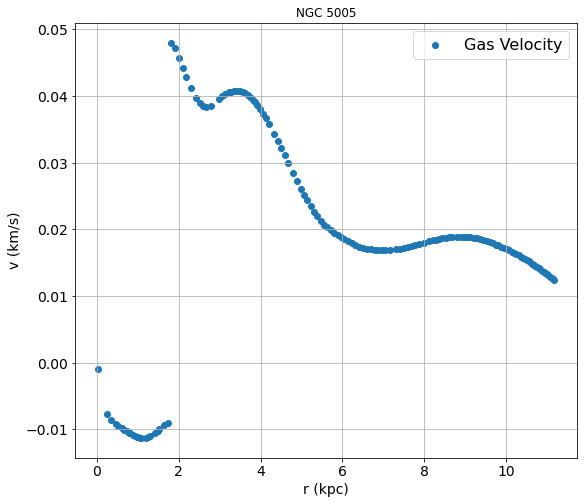

In [76]:
#plot disk velocity
fig = plt.figure(figsize=(9.0,8.0))                #size of the plot
ax = plt.axes()
ax.grid(True)
ax.yaxis.grid(True,which='minor',linestyle='--')

plt.scatter(radius, velocs, linestyle='solid', label='Gas Velocity')

plt.axis('tight');
ax.set(title='NGC 5005')              #labeling axes
#ax.set_xlim(0,11.4)
ax.set_xlabel('r (kpc)', fontsize=14)
ax.set_ylabel('v (km/s)', fontsize=14)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14);

plt.legend(fontsize=16);                                   #adding legend
#plt.savefig('DiskVelocity100pts.png')
plt.show()